In [4]:
noExt=function(x){
return(tools::file_path_sans_ext(x))
}
bnoExt=function(x){
return(basename(tools::file_path_sans_ext(x)))
}
fNumber=function(x){
sapply(x,FUN=function(x){
strsplit(x,"__")[[1]][2]
})
}
rRider=function(x){
sapply(x,FUN=function(x){
strsplit(x,"-RIDER")[[1]][1]
})
}
# centering with 'scale()'
center_scale <- function(x) {
    scale(x, scale = FALSE)
}
#LOAD LIBRARIES 
library(gtools);
library("GenomicRanges");
options(warn=-1)
library(ggplot2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb



In [5]:
#SETTING PATH 
pathGroseq="/sharedFolder/Data/5_CutTagAce/"
results="/sharedFolder/Results/Sequencing"
previousResults="/sharedFolder/Results/Hotspot/"


In [6]:
dir.create(results,recursive=TRUE)
results="/sharedFolder/Results/Sequencing/cutTagAce"
dir.create(results,recursive=TRUE)


In [7]:
gtf=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
gtf=gtf[grep("Ligase",gtf[,6]),]
a=list.files(pathGroseq,pattern=".bedgraph",recursive=TRUE)
uu=grep("sorted",a)
if(length(uu)!=0){
a=a[-uu]
    }
a=mixedsort(a)
a2=sapply(a,FUN=function(x){strsplit(x,".bedgraph")[[1]][1]})
groseq_count=matrix(0,ncol=length(unique(gtf[,7])),nrow=length(a2))
colnames(groseq_count)=sapply(unique(gtf[,7]),FUN=toString)
rownames(groseq_count)=a2
groseq_rpm=groseq_count
for(j in a){
    system(paste("echo",j))
temp=read.table(paste(pathGroseq,"/",j,sep=""),sep="\t")
tempGG=GRanges(seqnames=as.matrix(temp[,1]),ranges=IRanges(start = as.numeric(temp[,2]),end=as.numeric(temp[,3])),mcols=abs(as.numeric(temp[,4])))
    for(i in seq(nrow(gtf))){
        system(paste("echo",i/nrow(gtf)))
        gg=GRanges(seqnames=as.matrix(gtf[i,1]),ranges=IRanges(start = as.numeric(gtf[i,2]),end=as.numeric(gtf[i,3])))    
        over=findOverlaps(gg,tempGG)@to    
        name=as.vector(noExt((j)))
        groseq_count[name,toString(gtf[i,7])]= sum(tempGG[over]$mcols)
        groseq_rpm[name,toString(gtf[i,7])]= (sum(tempGG[over]$mcols)/sum(abs(temp[,4])))*1000000

   }

}
write.table((t(groseq_count)),paste(results,"/cutTagAce_AID_Heatmap_count.csv",sep=""),col.names=NA,sep=",")
write.table((t(groseq_rpm)),paste(results,"/cutTagAce_AID_Heatmap_RPM.csv",sep=""),col.names=NA,sep=",")


[1] "RAW"
[1] "Strongest"
[1] "Most DE"
[1] "Most DE with Threshold"


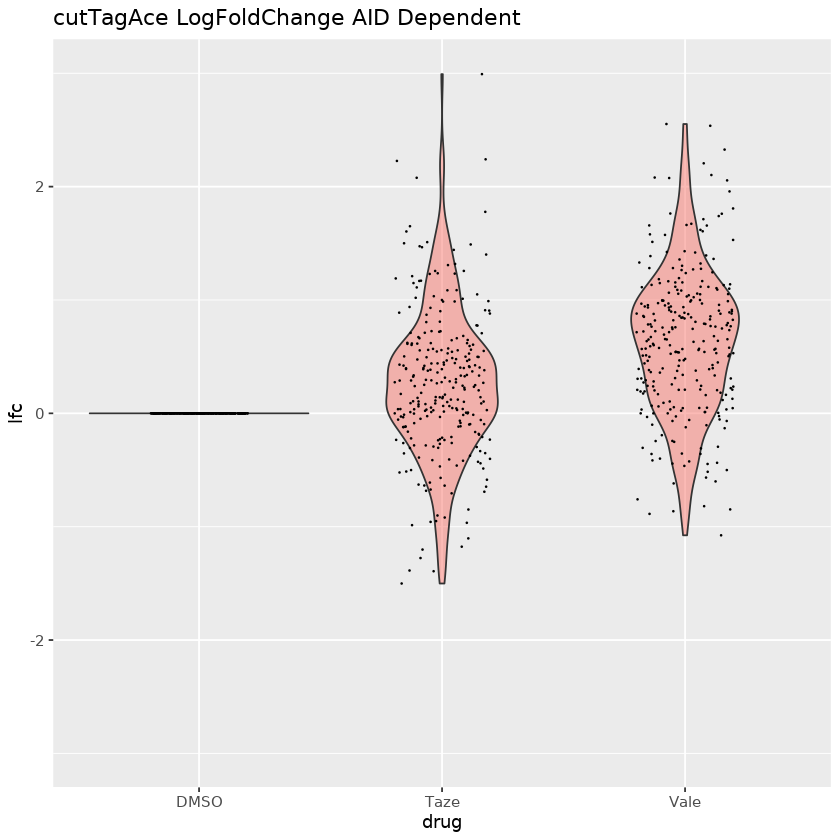

In [12]:
print("RAW")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagAce_newrpm=as.matrix(read.table(paste(results,"/cutTagAce_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))

ttmp=cutTagAce_newrpm[which(cutTagAce_newrpm[,1]>=summary(cutTagAce_newrpm[,1])[5]),]
thresholdTheBest=unique(union(names(sort(ttmp[,2]/ttmp[,1],decreasing=TRUE))[seq(1,20)],names(sort(ttmp[,3]/ttmp[,1],decreasing=TRUE))[seq(1,20)]))

foldChange=list()
geneWide=cutTagAce_newrpm+0.000001
filteringTazeBS=names(sort(geneWide[,2],decreasing=TRUE))[seq(1,75)]
filteringValeBS=names(sort(geneWide[,3],decreasing=TRUE))[seq(1,75)]
filteringBS=union(filteringTazeBS,filteringValeBS)


#geneWide=geneWide[filtering,]
foldChange[[1]]=log2(geneWide[,2]/geneWide[,1])
foldChange[[2]]=log2(geneWide[,3]/geneWide[,1])


filteringTazeLFC=names(sort(foldChange[[1]],decreasing=TRUE))[seq(1,75)]
filteringValeLFC=names(sort(foldChange[[2]],decreasing=TRUE))[seq(1,75)]
filteringLFC=union(filteringTazeLFC,filteringValeLFC)

filtering=intersect(filteringBS,filteringLFC)

names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill="red")) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2),size=0.1) +
theme(legend.position = "none") + ylim(-3,3) + ggtitle("cutTagAce LogFoldChange AID Dependent")
plot(pp)   
print("Strongest")
tempforever=c()
for(i in filtering){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/cutTagAce_raw_strongest.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
print("Most DE")
tempforever=c()

for(i in filteringLFC[seq(1,10)]){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))

}
write.table(tempforever,(paste(results,"/cutTagAce_raw_mostDE.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
tempforever=c()

print("Most DE with Threshold")
for(i in thresholdTheBest){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/cutTagAce_raw_mostDETreshold.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)

[1] "pvalue Filtered"
[1] "Strongest"
[1] "Most DE"
[1] "Most DE with Threshold"


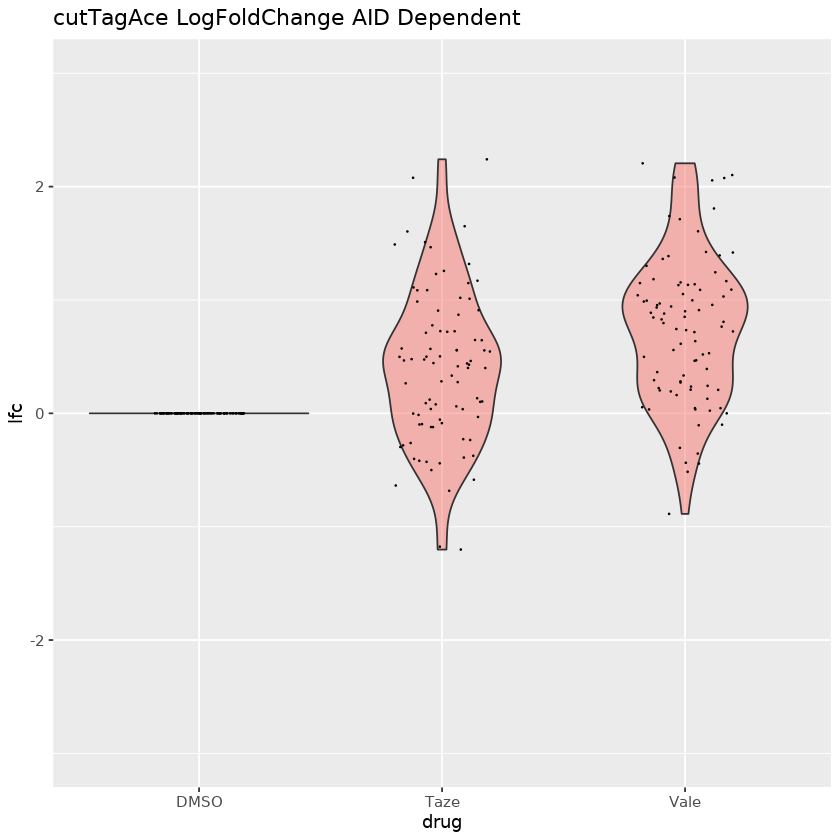

In [13]:
print("pvalue Filtered")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagAce_newrpm=as.matrix(read.table(paste(results,"/cutTagAce_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
filter=unique(union(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/filtered_Lig_DMSOVale.csv",header=TRUE,row.names=1,sep=",")),rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/filtered_Lig_DMSOTaze.csv",header=TRUE,row.names=1,sep=","))))
filter=unlist(sapply(filter,FUN=function(x){toString(x)}))
cutTagAce_newrpm=cutTagAce_newrpm[filter,]
write.table(cutTagAce_newrpm,paste(results,"/cutTagAce_AID_Heatmap_RPM_FILTERED.csv",sep=""),col.names=NA,sep=",")
ttmp=cutTagAce_newrpm[which(cutTagAce_newrpm[,1]>=summary(cutTagAce_newrpm[,1])[5]),]
thresholdTheBest=unique(union(names(sort(ttmp[,2]/ttmp[,1],decreasing=TRUE))[seq(1,20)],names(sort(ttmp[,3]/ttmp[,1],decreasing=TRUE))[seq(1,20)]))

foldChange=list()
geneWide=cutTagAce_newrpm+0.000001
filteringTazeBS=names(sort(geneWide[,2],decreasing=TRUE))[seq(1,75)]
filteringValeBS=names(sort(geneWide[,3],decreasing=TRUE))[seq(1,75)]
filteringBS=union(filteringTazeBS,filteringValeBS)


#geneWide=geneWide[filtering,]
foldChange[[1]]=log2(geneWide[,2]/geneWide[,1])
foldChange[[2]]=log2(geneWide[,3]/geneWide[,1])


filteringTazeLFC=names(sort(foldChange[[1]],decreasing=TRUE))[seq(1,75)]
filteringValeLFC=names(sort(foldChange[[2]],decreasing=TRUE))[seq(1,75)]
filteringLFC=union(filteringTazeLFC,filteringValeLFC)

filtering=intersect(filteringBS,filteringLFC)

names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill="red")) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2),size=0.1) +
theme(legend.position = "none") + ylim(-3,3) + ggtitle("cutTagAce LogFoldChange AID Dependent")
plot(pp)   
print("Strongest")
tempforever=c()
for(i in filtering){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/cutTagAce_filtered_strongest.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
print("Most DE")
tempforever=c()

for(i in filteringLFC[seq(1,10)]){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))

}
write.table(tempforever,(paste(results,"/cutTagAce_filtered_mostDE.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
tempforever=c()

print("Most DE with Threshold")
for(i in thresholdTheBest){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/cutTagAce_filtered_mostDETreshold.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)

In [ ]:
gtf=read.table("/sharedFolder/Data/refGene.gtf",header=TRUE,sep="\t")
a=list.files(pathGroseq,pattern=".bed",recursive=TRUE)
uu=grep("sorted",a)
if(length(uu)!=0){
a=a[-uu]
    }
a=mixedsort(a)
a2=sapply(a,FUN=function(x){strsplit(x,".bed")[[1]][1]})
cutTagAce_count=matrix(0,ncol=length(unique(gtf[,4])),nrow=length(a2))
colnames(cutTagAce_count)=sapply(unique(gtf[,4]),FUN=toString)
rownames(cutTagAce_count)=a2
cutTagAce_rpm=cutTagAce_count
for(j in a){
    system(paste("echo",j))
temp=read.table(paste(pathGroseq,"/",j,sep=""),sep="\t")
tempGG=GRanges(seqnames=as.matrix(temp[,1]),ranges=IRanges(start = as.numeric(temp[,2]),end=as.numeric(temp[,3])),mcols=abs(as.numeric(temp[,4])))
    for(i in seq(nrow(gtf))){
        system(paste("echo",i/nrow(gtf)))
        gg=GRanges(seqnames=as.matrix(gtf[i,1]),ranges=IRanges(start = as.numeric(gtf[i,2]),end=as.numeric(gtf[i,3])))    
        over=findOverlaps(gg,tempGG)@to    
        name=as.vector(noExt((j)))
        cutTagAce_count[name,toString(gtf[i,4])]= sum(tempGG[over]$mcols)
        cutTagAce_rpm[name,toString(gtf[i,4])]= (sum(tempGG[over]$mcols)/sum(abs(temp[,4])))*1000000

   }

}
conditions=c("DMSO","Taze","Vale")
cutTagAce_newcount=matrix(ncol=ncol(cutTagAce_count))
cutTagAce_newrpm=cutTagAce_newcount
 for(i in conditions){
summa=t(as.matrix(colSums(cutTagAce_count[grep(i,rownames(cutTagAce_count)),])))
cutTagAce_newcount=rbind(cutTagAce_newcount,summa)
summa=t(as.matrix(colSums(cutTagAce_rpm[grep(i,rownames(cutTagAce_rpm)),])))
cutTagAce_newrpm=rbind(cutTagAce_newrpm,summa)

}
cutTagAce_newrpm=cutTagAce_newrpm[-1,]
cutTagAce_newcount=cutTagAce_newcount[-1,]
rownames(cutTagAce_newrpm)=conditions
rownames(cutTagAce_newcount)=conditions

write.table((t(cutTagAce_newcount)),paste(results,"/cutTagAce_geneWide_count.csv",sep=""),col.names=NA,sep=",")
write.table((t(cutTagAce_newrpm)),paste(results,"/cutTagAce_geneWide_RPM.csv",sep=""),col.names=NA,sep=",")


[1] "filtered"
[1] "Strongest"
[1] "Most DE"
[1] "Most DE with Threshold"


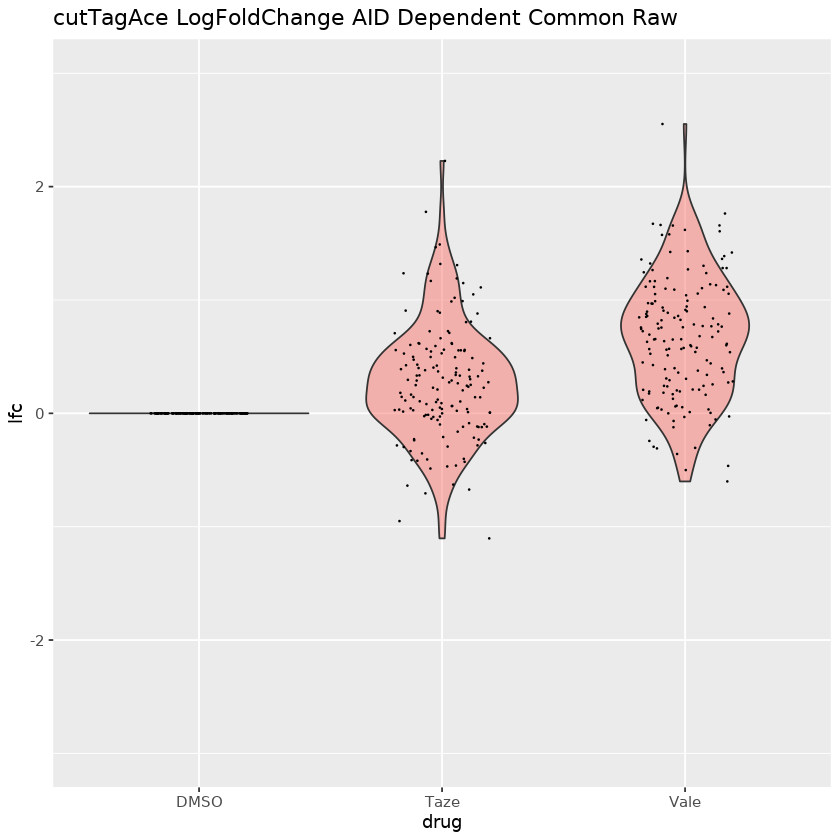

In [6]:
print("filtered")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagAce_newrpm=as.matrix(read.table(paste(results,"/cutTagAce_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
filter=unique(union(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/sortNames/_2_DMSO_TAZE.csv",header=TRUE,row.names=1,sep=",")),rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/sortNames/_5_DMSOVale.csv",header=TRUE,row.names=1,sep=","))))
filter=unlist(sapply(filter,FUN=function(x){toString(x)}))
cutTagAce_newrpm=cutTagAce_newrpm[filter,]

ttmp=cutTagAce_newrpm[which(cutTagAce_newrpm[,1]>=summary(cutTagAce_newrpm[,1])[5]),]
thresholdTheBest=unique(union(names(sort(ttmp[,2]/ttmp[,1],decreasing=TRUE))[seq(1,20)],names(sort(ttmp[,3]/ttmp[,1],decreasing=TRUE))[seq(1,20)]))

foldChange=list()
geneWide=cutTagAce_newrpm+0.000001
filteringTazeBS=names(sort(geneWide[,2],decreasing=TRUE))[seq(1,75)]
filteringValeBS=names(sort(geneWide[,3],decreasing=TRUE))[seq(1,75)]
filteringBS=union(filteringTazeBS,filteringValeBS)


#geneWide=geneWide[filtering,]
foldChange[[1]]=log2(geneWide[,2]/geneWide[,1])
foldChange[[2]]=log2(geneWide[,3]/geneWide[,1])


filteringTazeLFC=names(sort(foldChange[[1]],decreasing=TRUE))[seq(1,75)]
filteringValeLFC=names(sort(foldChange[[2]],decreasing=TRUE))[seq(1,75)]
filteringLFC=union(filteringTazeLFC,filteringValeLFC)

filtering=intersect(filteringBS,filteringLFC)

names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill="red")) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2),size=0.1) +
theme(legend.position = "none") + ylim(-3,3) + ggtitle("cutTagAce LogFoldChange AID Dependent Common Raw")
plot(pp)   
print("Strongest")
tempforever=c()
for(i in filtering){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/cutTagAce_raw_strongest.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
print("Most DE")
tempforever=c()

for(i in filteringLFC[seq(1,10)]){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))

}
write.table(tempforever,(paste(results,"/cutTagAce_raw_mostDE.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
tempforever=c()

print("Most DE with Threshold")
for(i in thresholdTheBest){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/cutTagAce_raw_mostDETreshold.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)

[1] "filtered"
[1] "Strongest"
[1] "Most DE"
[1] "Most DE with Threshold"


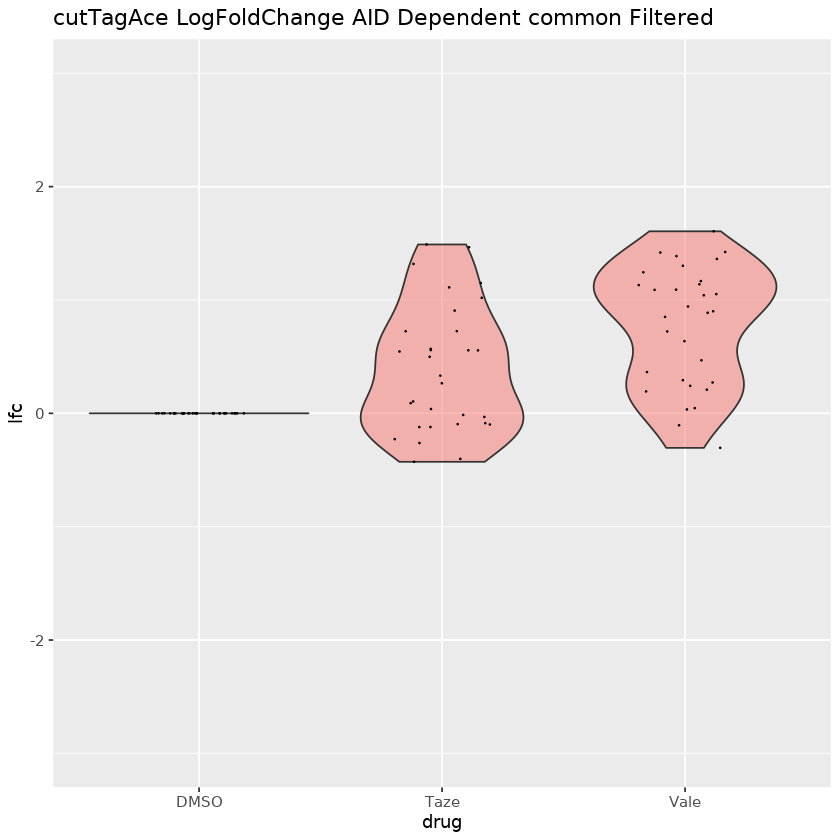

In [7]:
print("filtered")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagAce_newrpm=as.matrix(read.table(paste(results,"/cutTagAce_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
filter=unique(union(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/sortNames/_2_DMSO_TAZE.csv",header=TRUE,row.names=1,sep=",")),rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/sortNames/_5_DMSOVale.csv",header=TRUE,row.names=1,sep=","))))
filter=unlist(sapply(filter,FUN=function(x){toString(x)}))
cutTagAce_newrpm=cutTagAce_newrpm[filter,]

ttmp=cutTagAce_newrpm[which(cutTagAce_newrpm[,1]>=summary(cutTagAce_newrpm[,1])[5]),]
thresholdTheBest=unique(union(names(sort(ttmp[,2]/ttmp[,1],decreasing=TRUE))[seq(1,20)],names(sort(ttmp[,3]/ttmp[,1],decreasing=TRUE))[seq(1,20)]))

foldChange=list()
geneWide=cutTagAce_newrpm+0.000001
filteringTazeBS=names(sort(geneWide[,2],decreasing=TRUE))[seq(1,75)]
filteringValeBS=names(sort(geneWide[,3],decreasing=TRUE))[seq(1,75)]
filteringBS=union(filteringTazeBS,filteringValeBS)


#geneWide=geneWide[filtering,]
foldChange[[1]]=log2(geneWide[,2]/geneWide[,1])
foldChange[[2]]=log2(geneWide[,3]/geneWide[,1])


filteringTazeLFC=names(sort(foldChange[[1]],decreasing=TRUE))[seq(1,75)]
filteringValeLFC=names(sort(foldChange[[2]],decreasing=TRUE))[seq(1,75)]
filteringLFC=union(filteringTazeLFC,filteringValeLFC)

filtering=intersect(filteringBS,filteringLFC)

names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill="red")) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2),size=0.1) +
theme(legend.position = "none") + ylim(-3,3) + ggtitle("cutTagAce LogFoldChange AID Dependent common Filtered")
plot(pp)   
print("Strongest")
tempforever=c()
for(i in filtering){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/cutTagAce_raw_strongest.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
print("Most DE")
tempforever=c()

for(i in filteringLFC[seq(1,10)]){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))

}
write.table(tempforever,(paste(results,"/cutTagAce_raw_mostDE.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)
tempforever=c()

print("Most DE with Threshold")
for(i in thresholdTheBest){
temp=unique(Database[which(Database[,7]==i),c(1,2,3)])
tempforever=append(tempforever,(paste(temp[,1],":",temp[,2],"-",temp[,3],sep="")))
}
write.table(tempforever,(paste(results,"/cutTagAce_raw_mostDETreshold.csv",sep="")),sep=",",col.names=FALSE,row.names=FALSE,quote=FALSE)